# 通过检索增强生成（RAG）弥合知识鸿沟

---

如今我们的 LLM 已经能够记住关键决策并维持连贯的对话，是时候让它掌握**真正的知识**——关于*你的*任务、*你的*日程、*你的*项目文档。

目前你的 **TaskFriend** 应用只能依赖聊天过程中听到的信息。如果它还能：

* 拉取你即将到来的日程事件？
* 从数据库中读取你的任务清单？
* 查阅公司入职指南？

这正是 **检索增强生成（RAG）** 发挥作用的地方。

借助 RAG，你的 LLM 不再局限于预训练知识——它会从外部来源检索相关信息，并据此生成准确且个性化的回答。


## 到目前为止的故事……

**场景：**
用户喜欢与 **TaskFriend** 聊天，因为它能帮助他们规划一天的安排。你打造的功能——比如流式输出、多轮对话以及专业的系统提示——都广受好评！然而仍然存在一个空白：

**TaskFriend** 无法满意地回答如下问题：

> “本周我有哪些待办任务？”

或者：

> “如果我明早去健身房，可以重新安排演示准备时间吗？”

问题不在于 **TaskFriend** 不够聪明，而在于它**无法访问用户的真实数据**。它能记住对话里说过的话，却不了解用户世界里发生的事实。

## 课程目标

* 了解 RAG 如何让 LLM 的知识超越预训练范围
* 使用嵌入与向量检索构建文档检索系统
* 将检索到的上下文注入提示词以生成有依据的回答
* 处理私密、动态或频繁更新的信息

## 初始化环境

### 配置 API 密钥

在任何笔记本中开始之前，我们都需要加载 [Model Studio 的 API 密钥](https://modelstudio.console.alibabacloud.com/?tab=globalset#/efm/api_key)。这样我们才能调用本课程中将使用的 Qwen 模型接口。

> 如果你还不知道如何找到 **Model Studio** API 密钥，请参考 `00 Setting Up the Environment` 文件。

In [9]:
# Load Model Studio API key
import os
from config.load_key import load_key
load_key(
    confirmation=False
)

Detected existing API key: sk-8...2716
Auto-confirmation enabled. Using existing API key.


### 配置 LLM 与嵌入模型

我们将使用阿里云的 `qwen-plus` 作为 LLM，并使用 DashScope 的 `text-embedding-v3` 作为嵌入模型。

在本课程的这一部分，我们会改用 `OpenAILike` 而非之前使用的 `OpenAI`。`OpenAILike` 是 **LlamaIndex 的专用封装**，适用于所有兼容 OpenAI API 的模型，包括：

* Model Studio
* DashScope
* vLLM
* Ollama
* 其他具有 OpenAI 兼容 API 的本地 LLM


> **注意：** DashScope 的 API 端点为 `https://dashscope-intl.aliyuncs.com/api/v1`，不同于我们此前使用的 `https://dashscope-intl.aliyuncs.com/compatible-mode/v1`。

In [10]:
# Set global settings
import time
import logging
import dashscope
from llama_index.core import Settings, VectorStoreIndex, SimpleDirectoryReader
from llama_index.embeddings.dashscope import DashScopeEmbedding
from llama_index.llms.openai_like import OpenAILike
from pathlib import Path

logging.getLogger().setLevel(logging.ERROR)

# DashScope domestic endpoint
dashscope.base_http_api_url = "https://dashscope.aliyuncs.com/api/v1"

Settings.llm = OpenAILike(
    model="qwen-plus",
    api_base="https://dashscope.aliyuncs.com/compatible-mode/v1",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    is_chat_model=True
)

Settings.embed_model = DashScopeEmbedding(
    model_name="text-embedding-v3",
    api_key=os.getenv("DASHSCOPE_API_KEY"),
    encoding_format="float"
)

print("✅ Global parameters set!")

✅ Global parameters set!


# 独立 LLM 的局限性

---

在研读检索增强生成（RAG）之前，必须先认识到**独立大型语言模型（LLM）的内在限制**。虽然 LLM 能生成流畅连贯的文本，但它们既不无所不知，也并非绝对可靠。模型的行为完全取决于预训练语料与输入提示——这意味着它无法动态访问最新、私密或实时的信息。

理解这些局限，有助于我们在构建类似 **TaskFriend** 的真实场景应用时做出更好的增强决策。

## 关键限制

### 知识截止点

大多数 LLM 使用静态数据集进行训练，并且有固定的知识截止日期。例如：

* **阿里云 Qwen3：** 2025 年 4 月
* **OpenAI GPT 4.1：** 2024 年 6 月
* **Google Gemini 2.5 Pro：** 2025 年 1 月
* **Anthropic Claude 4 Opus：** 2025 年 3 月

这意味着模型**无法了解截止日期之后发布的事件、产品或研究**。

> **📌 例子：** 问一个基础模型“谁赢得了 2025 年欧冠？”——它要么猜测，要么编造答案。

即使模型很强大，它的知识也被时间冻结。

### 无法访问私有或内部数据

LLM 不会自动连接到你的个人任务列表、公司 Wiki 或内部 CRM。除非显式提供，它对下列信息**毫无认知**：

* 你的日程
* 你的项目笔记
* 公司政策
* 客户记录

没有增强的情况下，它们在个性化或企业级任务中显得**无能为力**。

> **🔐 安全提示：** 这种隔离从隐私角度看是好事——但这也意味着当我们需要时，必须**主动**为模型接入数据。

### 幻觉（Hallucinations）

当 LLM 缺乏足够信息时，往往会**信誓旦旦地生成虚假内容**——这就是所谓的“幻觉”。

> **🚨 示例：**  
 > **用户：** “Q2 报告的截止日期是什么时候？”  
 > **LLM：** “Q2 报告在 4 月 15 日截止。”  
 > **现实：** 并没有这份报告。

在生产力、法律、医疗或客户服务等场景下，这种情况极其危险。

## 替代方案及其不足

为了弥补这些缺陷，人们尝试过多种策略——但在成本、可扩展性和维护性上各有权衡。

| 方法 | 说明 | 局限 |
|------|------|------|
| **提示工程** | 通过精心设计提示（如系统提示、few-shot 示例）来引导模型行为 | 受上下文窗口限制；静态；对输入变化敏感 |
| **微调** | 在新增数据上再训练模型，使其内化新知识或风格 | 成本高；难以迭代；存在过拟合风险；不易版本化 |
| **纯检索** | 仅返回相关文档或片段而不生成内容 | 无法整合答案；需要用户自行阅读；缺乏自然语言输出 |

这些方法各有用武之地，但没有一种能在**准确性、时效性、成本与易维护性**之间实现完美平衡。

## LLM 增强的光谱：上下文 vs. 模型优化

我们增强 LLM 的思路存在一个根本性的权衡：

| 轴向 | 描述 |
|------|------|
| **模型优化** | 直接改变模型本身（如微调、蒸馏、继续预训练） |
| **上下文优化** | 保持模型不变，通过丰富输入上下文（如 RAG、提示工程、检索） |

由此形成一条策略光谱：  

<div style="text-align: center;">
  <img src="images/LMP-C01_03-Model Engineering Matrix.gif" style="max-width: 800px;" />
  <br>
  <small>LLM 优化矩阵</small>
  <br>
  <small><i>来源：<a href="https://platform.openai.com/docs/guides/optimizing-llm-accuracy" target="_blank">OpenAI - Optimizing LLM Accuracy</a></i></small>
</div>

# 什么是检索增强生成（RAG）？

---

**检索增强生成（Retrieval-Augmented Generation，RAG）** 是一种能够在生成过程中整合外部知识的强大技术。简而言之，RAG 允许 AI 在给出回答前，先从知识库中检索相关信息，使得答案更加准确、最新，并且基于真实数据。

RAG 是一种混合式方法，由两个核心组件组成：

* **检索（Retrieval）**：从庞大的数据集中找到最相关的信息片段。
* **生成（Generation）**：使用语言模型基于检索到的信息生成自然语言回答。

这种组合可以弥补独立 LLM 的一些不足，例如知识过时或容易产生幻觉。

## 为什么 RAG 很重要

传统 LLM 在训练时使用海量数据，但部署后知识即被固定，无法访问实时或私有数据，这使它们在许多应用场景里受限。RAG 则通过在推理时动态检索最相关的信息来解决这个问题。

| 问题 | 没有 RAG | 使用 RAG |
|------|---------|---------|
| “本周有哪些任务到期？” | 无法回答（无法访问数据） | 检索真实的任务清单 |
| “我需要拆解项目” | 只能给出泛泛建议 | 利用真实的项目笔记 |
| “公司有远程办公政策吗？” | 可能产生幻觉 | 检索 HR 文档 |

因此 RAG 尤其适用于：
* 企业环境（例如内部知识库）。
* 学术与研究场景（例如基于论文回答问题）。
* 客服支持（例如使用产品文档回答客户问题）。

借助 RAG，我们的 LLM 将从一个*被动的聊天机器人*升级为**主动的知识助手**！

## RAG 的核心流程

```mermaid
graph LR
    classDef frameworkStyle fill:#ffffff,stroke:#1f77b4,stroke-width:2px;
    
    subgraph flowchart[RAG 流程]
        subgraph "你的数据"
            A[(数据库)]
            B[文档]
            C[API]
        end

        U((用户))
        I[索引]
        L[LLM]

        A -- structured --> I
        B -- unstructured --> I
        C -- programmatic --> I

        U -- query --> I
        I -- "prompt +<br>query +<br>relevant data" --> L
        L -- response --> U
    end
    
    class flowchat frameworkStyle;
```

RAG 系统包含**三个阶段**：

### 阶段 1：检索

当用户提出问题时，系统首先要找到最相关的信息。这一步通过**检索模型**实现：它将查询转换成数值向量（嵌入），并在已经预先计算好嵌入的文档数据库中搜索最相似的条目。

例如，当用户询问 `“法国的首都是哪里？”` 时，系统可能会检索到 `“巴黎是法国的首都。”` 这样的文档。

### 阶段 2：增强

系统检索到相关文档后，会将它们作为**上下文**直接注入提示词，把一个通用的提问转化为包含数据的指令。

示例：

```mermaid
graph LR
    A["用户问题：<br>‘我的购物清单有哪些？’"] --> D((提示词))
    B["检索到的上下文：<br>‘- 面包<br>- 牛奶<br>- 果酱’"] --> D
    C[LLM] --> Response["回答：<br>‘你的购物清单包括：<br>面包、牛奶、果酱’"]
    
    subgraph "增强后的提示词"
        D --> E["‘基于以下信息：<br>- 面包<br>- 牛奶<br>- 果酱<br>请回答：我今天有哪些任务？’"]
    end

    E --> C
```

### 阶段 3：生成

LLM 基于检索到的数据生成自然语言回答，使内容更有根据、更准确，并显著降低幻觉风险。




# 理解嵌入与向量检索

RAG 的核心是向量检索，而向量检索的动力来自嵌入——即文本的稠密数值表示。

## 什么是嵌入？
嵌入是一种定长向量（例如长度为 `1024`），用于表示文本的语义含义。语义相似的文本会拥有相似的嵌入。

> 💡 类比：可以把文档想象成图书馆里的书，而嵌入就像 GPS 坐标——帮助我们找到最匹配的“邻居”。

## 向量检索是如何工作的？

* 将用户查询转换成嵌入向量。
* 在向量索引中搜索最相似的嵌入。
* 返回相似度最高的文档，并将其用于增强提示词。

这一过程依赖于**余弦相似度**——它衡量两段文本在语义上的相似程度，即便它们使用的词语不同。

**为什么“角度”比“距离”更重要**

想象每份文档（以及查询）都生活在一个高维空间里，比如 `1024` 维。虽然我们无法直观想象，但关键点如下：

**余弦相似度**关注的是两个向量之间的夹角，而非它们之间的距离。

* 如果两个向量几乎指向同一个方向 → 相似度高
* 如果指向相反方向 → 相似度低

> **实用小贴士：**  
 > 将嵌入理解为从原点射出的箭矢。  
 > 即使某支箭更长（例如文档较长），真正重要的是它的指向。  
 > 两支箭朝向相同方向，意味着它们的含义相近，而余弦相似度正是捕捉这种关系的工具。

🧠 Generating embeddings using DashScope...


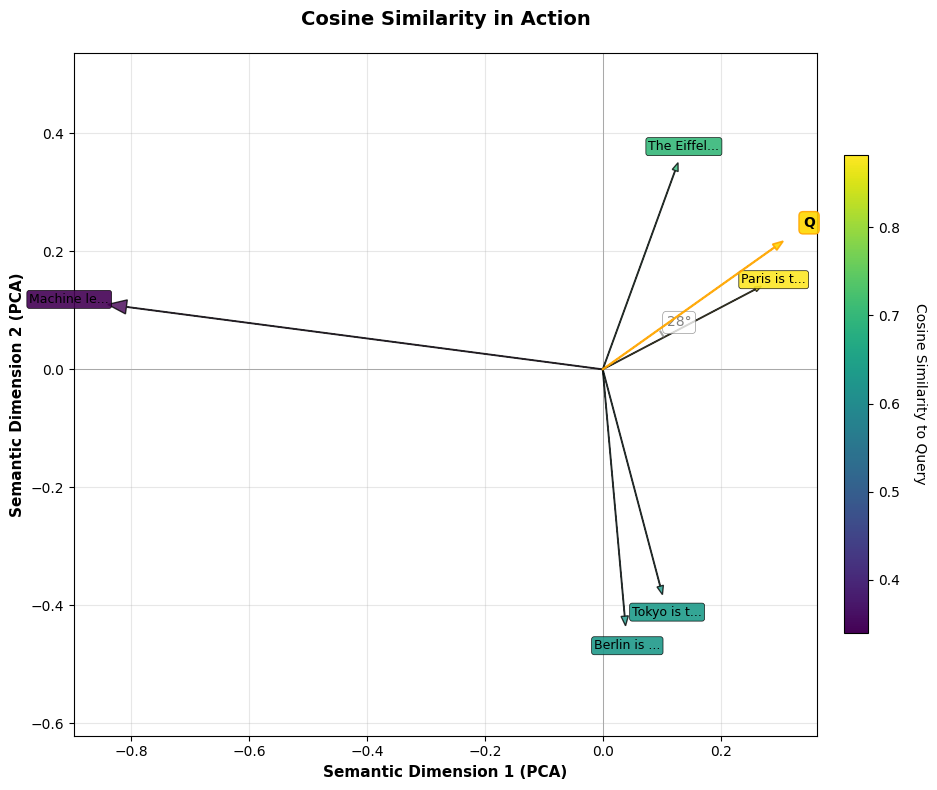


🔍 Top Matches:
  1. [0.882] Paris is the capital of France.
  2. [0.701] The Eiffel Tower is in Paris.
  3. [0.636] Tokyo is the capital of Japan.
  4. [0.630] Berlin is the capital of Germany.
  5. [0.339] Machine learning is a subset of artificial intelligence.


In [11]:
# Step 1: Use configured embedding model
embed_model = Settings.embed_model

# Step 2: Sample documents
docs = [
    "Paris is the capital of France.",
    "The Eiffel Tower is in Paris.",
    "Berlin is the capital of Germany.",
    "Tokyo is the capital of Japan.",
    "Machine learning is a subset of artificial intelligence."
]

# Step 3: Import and plot
from functions.vector_visualization import plot_vector_search

query = "What is the capital city of France?"

plot_vector_search(embed_model, docs, query)

# 手把手搭建 RAG 系统

下面我们将使用 `llama_index`、`DashScope` 以及本地 `documents` 目录，一步步搭建一个可工作的 RAG 系统。

## 第 1 步：加载文档

LlamaIndex 提供的 `SimpleDirectoryReader` 可以从 `./docs/taskfriend` 目录中加载文件。

> **注意：** `SimpleDirectoryReader` 可能将文件拆分成多个片段。  
 > 在我们的示例中，嵌入模型最多会处理 10 个片段。

In [12]:
# Load the documents
documents = SimpleDirectoryReader(
    input_dir="./docs/taskfriend",
    required_exts=[".pdf"],
    recursive=False
).load_data()

print(f"\n📄 Raw documents loaded: {len(documents)}")
for doc in documents:
    print(f" - {Path(doc.metadata['file_path']).name} (Text len: {len(doc.text)})")


📄 Raw documents loaded: 6
 - tasks.pdf (Text len: 432)
 - tasks.pdf (Text len: 457)
 - tasks.pdf (Text len: 422)
 - tasks.pdf (Text len: 510)
 - tasks.pdf (Text len: 477)
 - tasks.pdf (Text len: 322)


## 第 2 步：构建并保存索引

接下来，我们使用 LlamaIndex 的 `VectorStoreIndex.from_documents()` 函数从已加载的文档构建向量索引，并将其持久化到磁盘。

> **专业提示：** 持久化到磁盘可以避免每次都重新构建索引，从而提升 RAG 的响应速度。

In [13]:
# Build index from documents
print("Creating index...", end="", flush=True)
start_time = time.time()

index = VectorStoreIndex.from_documents(
    documents,
    embed_model=Settings.embed_model
)

load_time = time.time() - start_time
print(f" Done ✓ ({load_time:.1f} seconds)")

# Save index
index.storage_context.persist("knowledge_base/taskfriend")
print("✅ Index built and saved")

Creating index... Done ✓ (0.4 seconds)
✅ Index built and saved


In [14]:
from llama_index.core import SimpleDirectoryReader
import logging

logging.getLogger().setLevel(logging.ERROR)

documents = SimpleDirectoryReader(
    input_dir="./docs/taskfriend",
    required_exts=[".pdf"],
    recursive=False
).load_data()

print("Raw chunks:")
for i, doc in enumerate(documents):
    print(f"\n--- Chunk {i+1} ---\n")
    print(doc.text)

Raw chunks:

--- Chunk 1 ---

TaskFriend Task Database  What is TaskFriend?  TaskFriend is a helpful AI-assistant that helps with managing your daily tasks, and provides advice on =me management and project scheduling.  What are tasks?  Tasks are the smallest denomina=on of work you can achieve in TaskFriend. You can set tasks, type, due dates, status, and notes. This gives you full insight into your life and priori=es, helping you beBer manage your =me.    

--- Chunk 2 ---

Tasks   ID Task Type Due Status Notes 
01 Finalize Q3 OKRs by 3pm One-oﬀ Today Pending  Collaborate with department heads to align on measurable objecDves, lay out solid plan to achieve objecDves and assign responsibility to team members.   
02 Prepare presentaDon for client review One-oﬀ This Week Pending  Focus on deliverables from Q2, highlight success metrics, and outline next steps. Obtain client feedback on presentaDon and tweak direcDon based on 

--- Chunk 3 ---

client preferences.   
03 Onboard new team 

## 第 3 步：查询 RAG 系统

现在我们使用 `index.as_query_engine()` 创建 `query_engine`，然后封装一个多轮对话函数，让 **TaskFriend** 应用可以直接调用。

In [15]:
from taskfriend.chat import chat_interface, wrap_rag_for_chat

# Build the query engine (used to implement RAG)
query_engine = index.as_query_engine(
    streaming=True,
    llm=Settings.llm,
)

# 📝 Define & initialize full_conversation
full_conversation = []

def get_rag_response(question, query_engine):
    
    try:
        # 🔍 Query the RAG engine
        response = query_engine.query(question)

        # 🧠 Extract the answer
        if hasattr(response, 'response'):
            answer = response.response
        else:
            answer = str(response)

        return answer

    except Exception as e:
        print(f"[RAG Error] {e}")
        return "[Error retrieving response]"


# Wrap function for compatibility
wrapped_rag = wrap_rag_for_chat(
    get_rag_response,
    query_engine=query_engine,
)

# Start chat with RAG
chat_interface(
    full_conversation=full_conversation,
    # client=client,
    call_llm_fn=wrapped_rag,
)

🚀 TaskFriend Conversation
------------------------------------------------------------
👤 You: 今天有哪些任务到期？
🤖 TaskFriend: 今天到期的任务是：在下午3点前完成Q3 OKR的最终确定。该任务状态为“待处理”，需要与各部门负责人协作，明确可衡量的目标，制定实现目标的详细计划，并分配责任人。 
👤 You: 本周有那些任务到期？

🤖 TaskFriend is thinking...
🤖 TaskFriend: 本周到期的任务包括：在下午3点前完成Q3 OKR的最终确定，以及准备客户评审的演示材料。其中，Q3 OKR任务需与各部门负责人协作，明确可衡量的目标，制定实现目标的详细计划，并分配责任人；演示材料需聚焦Q2的交付成果，突出关键成果指标，概述后续步骤，并根据客户反馈调整方向。两项任务当前状态均为“待处理”。 

------------------------------------------------------------
💡 Type your next message (or 'exit', 'bye' to end):

👋 Ending conversation... See you next time!


现在可以尝试向模型提问：

```
"今天有哪些任务到期？"
"本周有哪些任务到期？"
```

恭喜！你已经成功构建了第一个 RAG！  
模型现在可以读取 `./docs/taskfriend` 中的 `tasks.pdf`，回答和你的任务相关的问题。如果找不到 `tasks.pdf`，下面是任务表格：


| ID | 任务 | 类型 | 截止 | 状态 | 备注 |
|----|------|------|-----|--------|-------|
| 01 | 在下午 3 点前完成 Q3 OKR | 一次性 | 今天 | 待办 | 与部门负责人合作，统一可量化目标，制定实现计划并分配责任。 |
| 02 | 准备客户评审演示文稿 | 一次性 | 本周 | 待办 | 聚焦第二季度的交付成果，突出成功指标并规划下一步。获取客户反馈并按照客户偏好调整方向。 |
| 03 | 新成员入职 | 一次性 | 今天 | 已完成 | 安排与团队成员的见面会，发送包含入职清单的欢迎邮件，为入职前 30 天指定导师。<br>Karen 已被指定为新成员的导师。 |
| 04 | 审阅团队反馈问卷结果 | 一次性 | 本周 | 待办 | 分析最新员工敬业度调查的匿名反馈，找出前三大痛点和两个优势。 |
| 05 | 更新 Project Phoenix 路线图 | 一次性 | 今天 | 待办 | 与项目负责人同步最新时间线、里程碑和资源分配，考虑最新的供应链波动。 |
| 06 | 安排团队 1:1 | 一次性 | 本月 | 待办 | 在接下来的四周内为每位团队成员预订 30 分钟会议，重点讨论职业规划、工作负载与反馈。 |
| 07 | 致电银行咨询房贷 | 一次性 | 本周 | 待办 | 联系客服了解再融资选项，对比当前利率与市场利率，咨询提前还款罚金及基于现状获取更好条款的可能性。 |
| 08 | 每周报告：Project Phoenix | 循环任务 | 本周 | 已开始 | 汇总交付物进度、阻塞点与资源使用情况，每周五工作日结束前通过钉钉分享报告。 |
| 09 | 制定三年规划 | 一次性 | 今年 | 待办 | 基于公司战略调整与市场趋势，为团队拟定长期愿景，并在年度规划会议上展示草案。 |
| 10 | 给韩国笔友写感谢信 | 一次性 | 今天 | 已开始 | 感谢笔友在你计划挪威旅行时给予的帮助，并记得询问对方刚出生的儿子 Edwin 的近况。 |


不过你会发现这个 RAG 还不完美——它给出的答案并未覆盖所有任务。继续与 **TaskFriend** 对话，会发现还有不少问题它无法准确回答。我们将在下一章节继续优化。

# 接下来做什么？

## 自测一下！

<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>1. 以下哪一项是独立 LLM 的关键限制，而 RAG 能够帮助解决？</b>  

<ul>
    <li>A) 高昂的 API 成本  </li>
    <li>B) 无法生成流畅文本  </li>
    <li>C) 无法访问私有或实时数据  </li>
    <li>D) 推理速度慢</li>
</ul>

**查看答案 →**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** C) 无法访问私有或实时数据  
 📝 **解释：**
* RAG 使 LLM 能够检索并利用最新且与用户相关的信息（例如任务或日程）。

</div>
</details>

<br>

<details>
<summary style="cursor: pointer; padding: 12px; border: 1px solid #dee2e6; border-radius: 6px;">
<b>2. 在 RAG 流程中，“增强”阶段发生了什么？</b>  

<ul>
    <li>A) 重新训练嵌入模型  </li>
    <li>B) 模型在新文档上进行微调  </li>
    <li>C) 用户看到原始搜索结果  </li>
    <li>D) 将检索到的文档作为上下文加入提示词</li>
</ul>

**查看答案 →**
</summary>

<div style="margin-top: 10px; padding: 15px; border: 1px solid #dee2e6; border-radius: 0 0 6px 6px;">

✅ **正确答案：** D) 将检索到的文档作为上下文加入提示词  
 📝 **解释：**
* 这样可以让 LLM 基于真实数据给出回答。

</div>
</details>

## 核心要点

* **独立 LLM 的局限**
    * **知识截止点** 让模型无法了解训练时间之后的事件或数据（例如 Qwen3：2025 年 4 月）。
    * **无法访问私有或内部数据**——除非显式提供，模型看不到你的日程、任务或公司文档。
    * **幻觉** 出现在模型缺少信息时，它会编造看似合理但错误的回答。
    * **替代方案各有取舍**：
      * *提示工程*：受限于上下文窗口。
      * *微调*：成本高、难以更新。
      * *纯检索*：只返回原文，没有自然语言整合。
    * **RAG 通过推理时动态注入真实、最新、与用户相关的上下文来解决这些问题。**

<br>

* **RAG 系统**
    * **RAG 构建桥梁**，连接通用知识与私有、实时数据。
    * 它结合两大组件：
      - **检索**：从知识库中找到相关文档。
      - **生成**：使用 LLM 基于检索内容生成自然语言回答。
    * **RAG 让 LLM 脱胎换骨**，从静态聊天机器人变成动态知识助手。
    * 它能准确、个性化地回答如下问题：
      - “本周有哪些任务到期？”
      - “我可以重新安排演示准备时间吗？”
    * **RAG 属于上下文优化**，而非模型优化——模型保持不变，但输入更丰富。

<br>

* **嵌入与向量检索**
    * **嵌入** 是稠密向量（例如长度 1024），用来表示语义。
    * **语义相近的文本拥有相似嵌入**——从而实现超越关键词匹配的语义搜索。
    * **向量检索** 通过比较查询和文档嵌入来找到最相关的文档。
    * **余弦相似度** 通过向量夹角衡量语义一致性：
      - 夹角小 → 相似度高
      - 方向相反 → 相似度低
    * **嵌入让系统理解** “法国的首都”与“巴黎”之间的关系，即使词语不同。

<br>

* **构建 RAG 系统**
    * **第 1 步：加载文档** —— 通过 `SimpleDirectoryReader` 等工具读取 PDF、文本或 API 数据。
    * **第 2 步：构建向量索引** —— 将文档转换为嵌入并存储，方便快速检索。
    * **第 3 步：持久化索引** —— 保存到磁盘，避免重复构建。
    * **第 4 步：检索 + 增强** —— 找到相关上下文并注入提示词。
    * **RAG 流水线：**
      1. **检索：** 将查询转换为嵌入 → 找到最匹配的文档。
      2. **增强：** 将检索内容作为上下文加入提示词。
      3. **生成：** LLM 生成有依据、准确的回答。
    * **RAG 是迭代式的**——第一版可能不完美，但它是持续改进的基础。